**IMPORTS**

In [1]:
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

**SET RANDOM SEEDS**

In [2]:
# SET RANDOM SEEDS FOR REPRODUCIBILITY

torch.manual_seed(42)

**CHECK FOR GPU**

In [3]:
# CHECK FOR GPU

device = torch.device(
    'cuda' if torch.cuda.is_available()
    else 'cpu'
)


print(f"Using device: {device}")

Using device: cuda


**LOAD DATA**

In [ ]:
df = pd.read_csv('/content/fashion-mnist_train.csv')


df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**DISPLAY DATA SHAPE**

In [5]:
df.shape

(60000, 785)

**DISPLAY IMAGES**

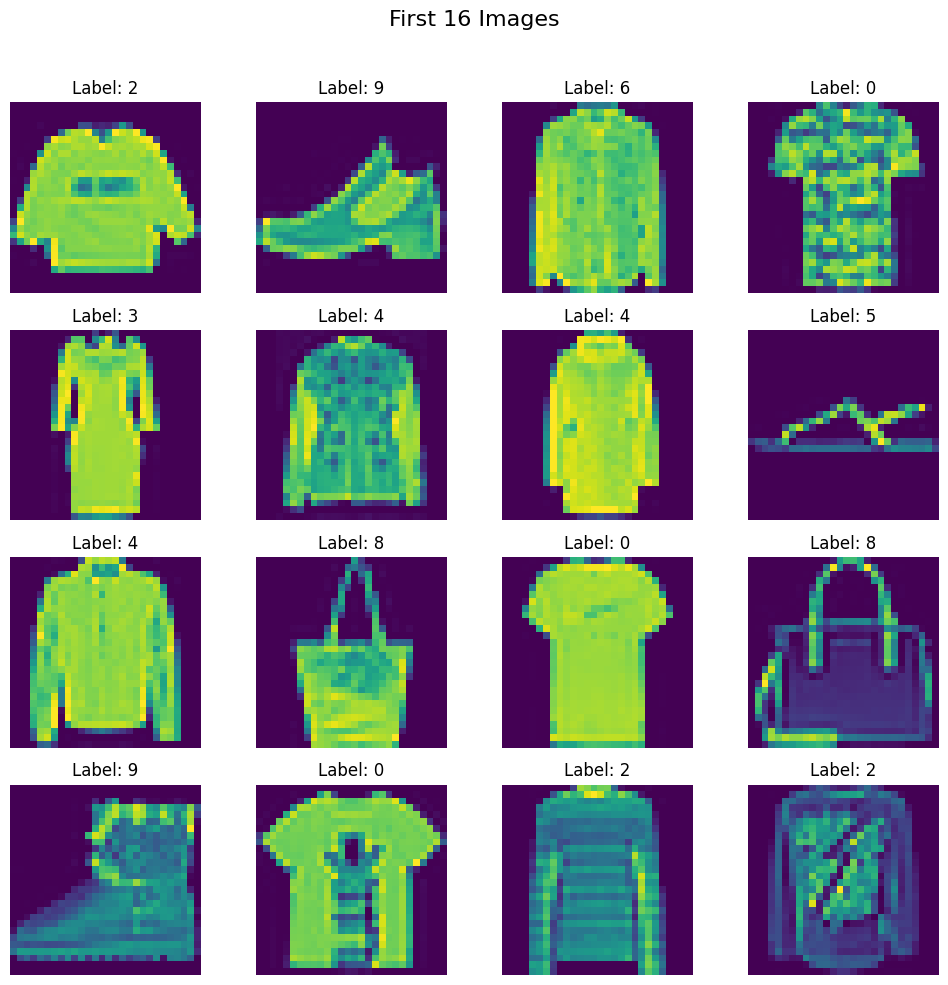

In [6]:
# CREATE A 4X4 GRID OF IMAGES
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle("First 16 Images", fontsize=16)



# PLOT THE FIRST 16 IMAGES FROM THE DATASET
for i, ax in enumerate(axes.flat):
    # RESHAPE TO 28x28
    img = df.iloc[i, 1:].values.reshape(28, 28)

    # DISPLAY IN GRAYSCALE
    ax.imshow(img)

    # REMOVE AXIS FOR A CLEANER LOOK
    ax.axis('off')

    # SHOW THE LABEL
    ax.set_title(f"Label: {df.iloc[i, 0]}")



plt.tight_layout(rect=[0, 0, 1, 0.96])  # ADJUST LAYOUT TO FIT THE TITLE
plt.show()

**SPLIT DATA**

In [7]:
# TRAIN TEST SPLIT

X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

**NORMALIZE DATA**

In [9]:
X_train = X_train/255.0

X_test = X_test/255.0

**CUSTOM DATASET CLASS**

In [10]:
class CustomDataset(Dataset):

  def __init__(self, features, labels):

    # Convert to PyTorch tensors
    self.features = torch.tensor(features, dtype=torch.float32).reshape(-1,1,28,28)
    self.labels = torch.tensor(labels, dtype=torch.long)



  def __len__(self):
    return len(self.features)



  def __getitem__(self, index):
    return self.features[index], self.labels[index]

**CREATE TRAINING DATASET**

In [11]:
train_dataset = CustomDataset(
    X_train,
    y_train
)

**CREATE TESTING DATASET**

In [12]:
test_dataset = CustomDataset(
    X_test,
    y_test
)

**CREATE DATA LOADERS**

In [13]:
train_loader = DataLoader(
  train_dataset,
  batch_size=32,
  shuffle=True,
  pin_memory=True
)



test_loader = DataLoader(
  test_dataset,
  batch_size=32,
  shuffle=False,
  pin_memory=True
)

**DEFINE NEURAL NETWORK**

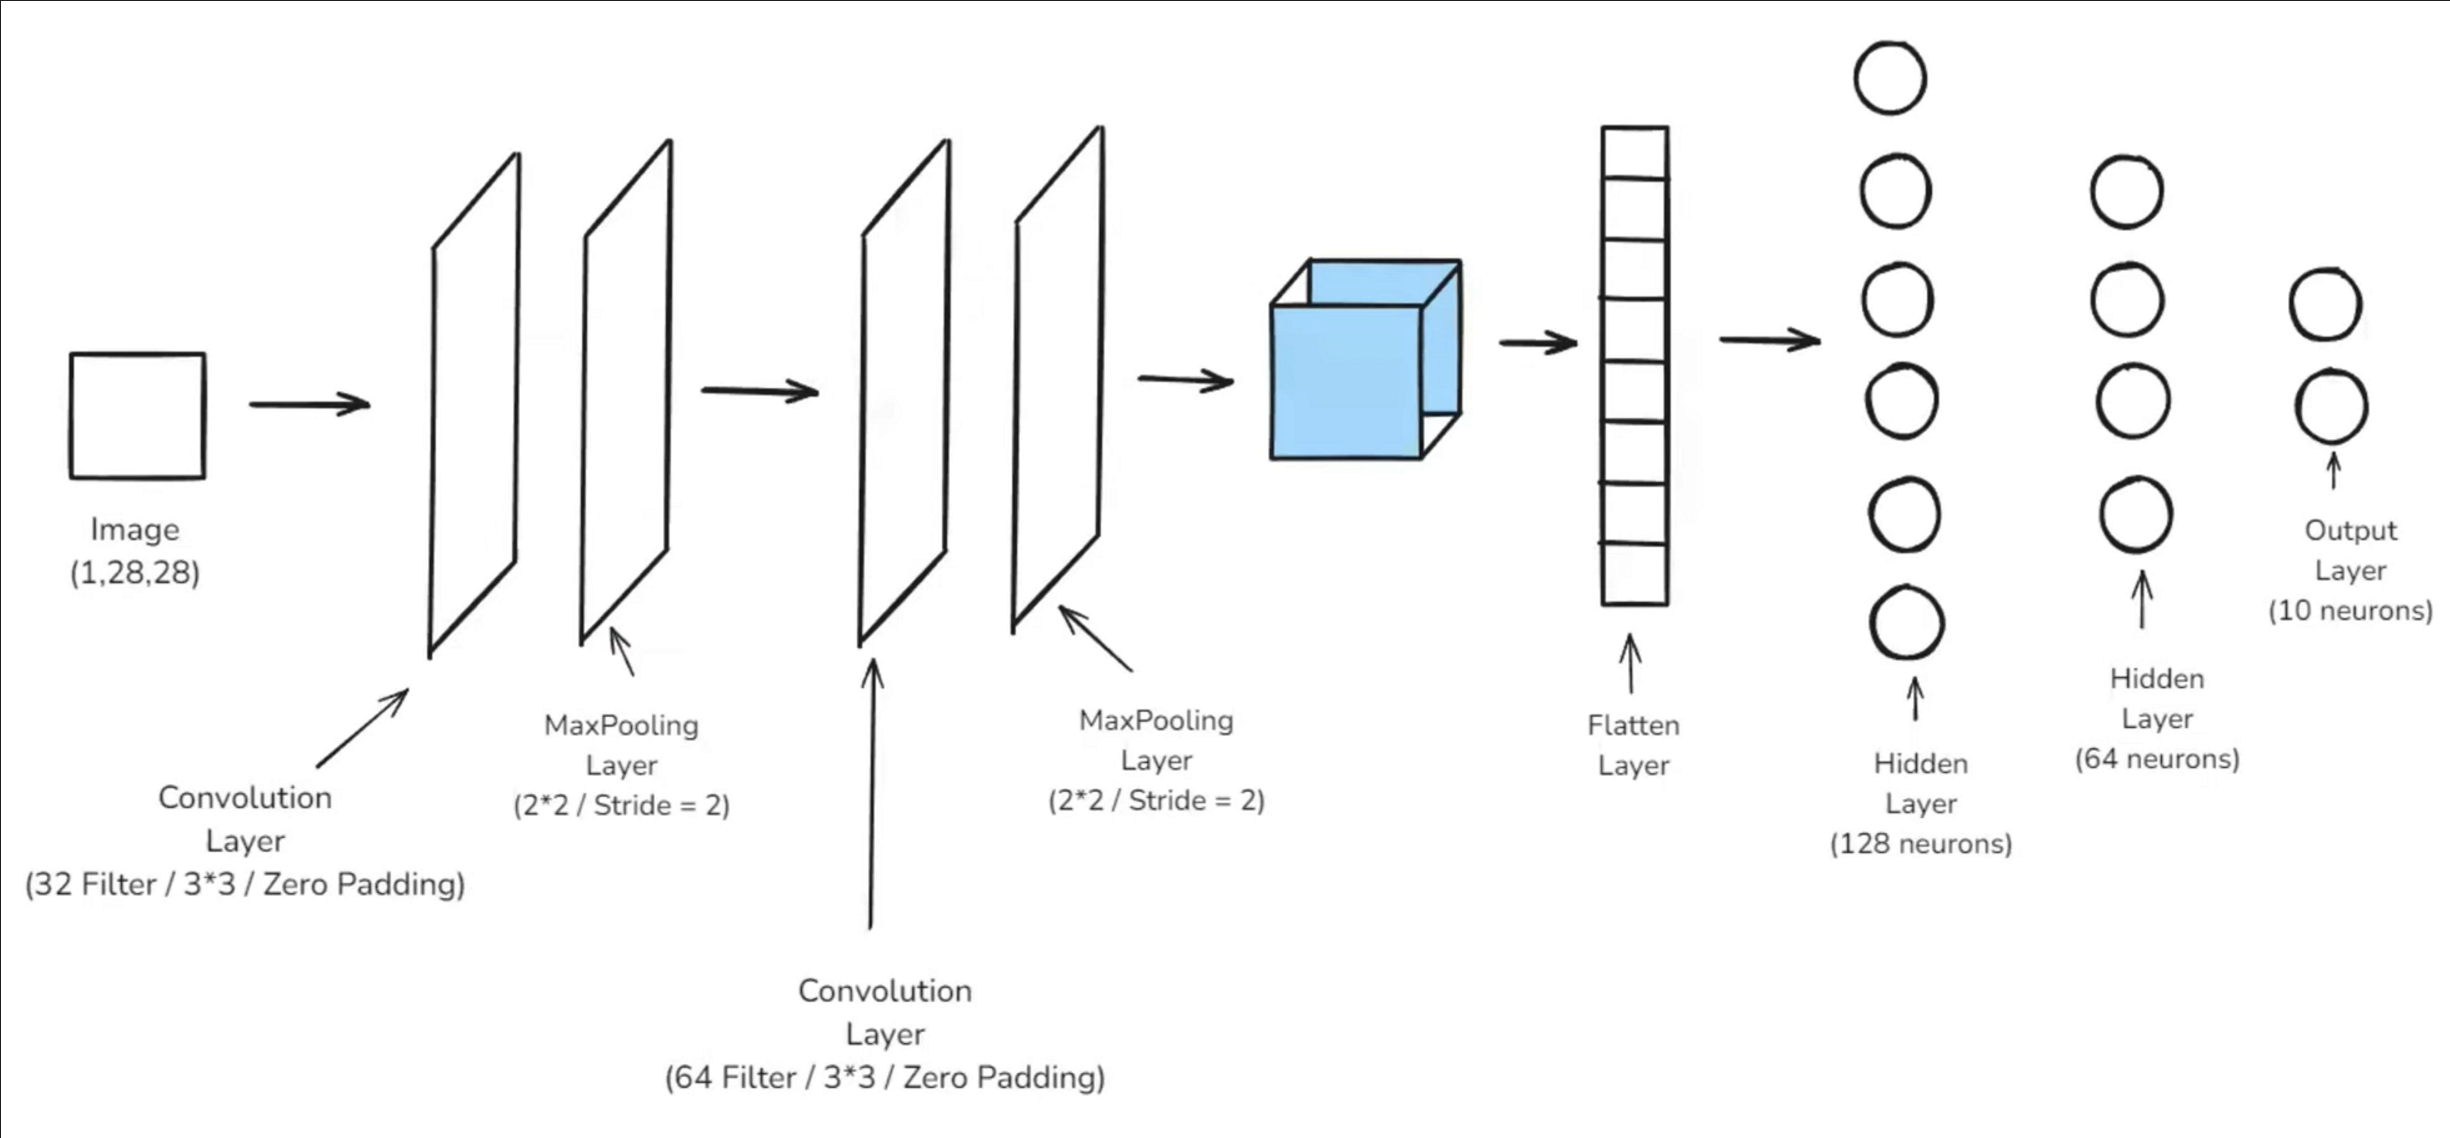

In [14]:
class MyNN(nn.Module):
    def __init__(self):

        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding='same'),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),

            nn.Linear(64*7*7, 128),
            nn.ReLU(),
            nn.Dropout(p=0.4),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(p=0.4),

            nn.Linear(64, 10)
        )


    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)

        return x

**SET HYPERPARAMETERS**

In [15]:
learning_rate = 0.1

epochs = 100

**INITIALIZE MODEL, LOSS FUNCTION, AND OPTIMIZER**

In [16]:
model = MyNN()
model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    model.parameters(),
    lr=learning_rate,
    weight_decay=1e-4
)

**TRAINING LOOP**

In [17]:
# TRAINING LOOP

for epoch in range(epochs):

  total_epoch_loss = 0

  for batch_features, batch_labels in train_loader:

    # MOVE DATA TO GPU
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    # FORWARD PASS
    outputs = model(batch_features)

    # CALCULATE LOSS
    loss = criterion(outputs, batch_labels)

    # BACK PASS
    optimizer.zero_grad()
    loss.backward()

    # UPDATE GRADS
    optimizer.step()

    total_epoch_loss = total_epoch_loss + loss.item()


  avg_loss = total_epoch_loss/len(train_loader)
  print(f'Epoch: {epoch + 1} , Loss: {avg_loss}')

Epoch: 1 , Loss: 0.6692613670726617
Epoch: 2 , Loss: 0.44847238036990167
Epoch: 3 , Loss: 0.3805455071677764
Epoch: 4 , Loss: 0.33976004406313104
Epoch: 5 , Loss: 0.3136404046912988
Epoch: 6 , Loss: 0.28974550317972897
Epoch: 7 , Loss: 0.2726129433549941
Epoch: 8 , Loss: 0.2580894807651639
Epoch: 9 , Loss: 0.24722210540249945
Epoch: 10 , Loss: 0.2373280042099456
Epoch: 11 , Loss: 0.22344917997779945
Epoch: 12 , Loss: 0.2148784095061322
Epoch: 13 , Loss: 0.20643764398060738
Epoch: 14 , Loss: 0.19986469152135153
Epoch: 15 , Loss: 0.18999458780698478
Epoch: 16 , Loss: 0.18265429210911194
Epoch: 17 , Loss: 0.1785801907988886
Epoch: 18 , Loss: 0.1759767425407966
Epoch: 19 , Loss: 0.1649163849192361
Epoch: 20 , Loss: 0.16154070156564315
Epoch: 21 , Loss: 0.15568927493784576
Epoch: 22 , Loss: 0.15316703530214726
Epoch: 23 , Loss: 0.14914444371374944
Epoch: 24 , Loss: 0.14178773631931593
Epoch: 25 , Loss: 0.14155373090133072
Epoch: 26 , Loss: 0.13680898675726105
Epoch: 27 , Loss: 0.13419351808

**SET MODEL TO EVALUATION MODE**

In [18]:
model.eval()

MyNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.4, inplace=False)
    (7): Linear(in_features=64, out_features=10, bias=True)
  )
)

**EVALUATE ON TEST DATA**

In [19]:
# EVALUATION ON TEST DATA
total = 0
correct = 0

with torch.no_grad():
  for batch_features, batch_labels in test_loader:

    # MOVE DATA TO GPU
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = model(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.92125


**EVALUATE ON TRAINING DATA**

In [20]:
# EVALUATION ON TRAINING DATA
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in train_loader:

    # MOVE DATA TO GPU
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = model(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.997125
